In [1]:
#import scrublet as scr
import numpy as np
import pandas as pd
import statistics as st
import re
import csv
import scanpy as sc 
import scanpy.external as sce
import phate
import matplotlib
from matplotlib import pyplot as plt
import warnings
from scipy.stats import binom
from scipy.stats import multinomial
import seaborn as sns
from scipy.stats import hypergeom
import warnings
warnings.filterwarnings('ignore')
import scrublet as scr
import harmonypy as hm
import pickle
from random import sample
from matplotlib_venn import venn2
from _util_updated import cluster_bias

### Load Dataset

In [2]:
#SG_DF = pd.read_pickle('./Focused_SG_DF.pkl')

In [3]:
#SC_DF = sc.read_h5ad('./Validation_SC_DF.h5ad')

In [4]:
PATH = '../../Data/Pickles/'
Dict_File = open(PATH + "Guide_Dictionary_Filtered.pkl", "rb")
CM_FILTERED_DICT = pickle.load(Dict_File)

### Process sgRNA

In [5]:
cell_list = []
for cell in SG_DF.index:
    if cell in SC_DF.obs.index:
        cell_list.append(cell)
SG_DF = SG_DF.loc[cell_list]

In [6]:
### Make Dict of sgRNA 
SG_Targets = []
for sg in SG_DF.columns:
    SG_Targets.append(sg.split('_')[0])
SG_Targets = np.unique(SG_Targets)

SG_Name = []
SG_Indi = []
for sg in SG_Targets:
    if sg == 'NC_Blank':
        SG_Name.append('NC')
        SG_Indi.append('NC_Blank')
    else:
        SG_Name.append(sg)
        sg_list = []
        for indi in SG_DF.columns:
            if indi.split('_')[0] == sg:
                sg_list.append(indi)
        SG_Indi.append(sg_list)
Guide_Dictionary = dict(zip(SG_Name, SG_Indi))

In [7]:
### Cells for each sgRNA
Cell_List = []
for target in SG_DF.columns:
    Cell_Subset = []
    if target == 'NC_Blank':
        for cell in SG_DF.index:
            if sum(SG_DF.loc[cell] >0) != 1:
                continue
            if SG_DF.loc[cell][target] >0:
                Cell_Subset.append(cell)
    else:
        [Cell_Subset.append(i) for i in SG_DF[SG_DF[target] > 0].index]
    Cell_List.append(Cell_Subset)
SG_Dictionary = dict(zip(SG_DF.columns, Cell_List))

In [8]:
### List of perturbed cells
Perturbed_Cells = []
for target in Guide_Dictionary.keys():
    if target == 'NC':
        continue
        
    Filtered_SG = [i for i in Guide_Dictionary[target] if int(i.split('_')[1]) not in CM_FILTERED_DICT[target]]
    for i in Filtered_SG:
        Perturbed_Cells.extend(SG_Dictionary[i])
    
Perturbed_Cells = np.unique(Perturbed_Cells)

In [9]:
sg_id = []
for cell in SC_DF.obs.index:
    if cell in SG_Dictionary['NC_Blank']:
        sg_id.append('NC')
    elif cell in Perturbed_Cells:
        sg_id.append('TBX5_ENH')
    else:
        sg_id.append('Other')
SC_DF.obs['sg_id'] = sg_id

In [10]:
SC_DF_Perturbed = SC_DF[SC_DF.obs.sg_id != 'Other']

### Run HyperGeo

In [21]:
tran_matrix = SC_DF

dep_target_values = []
enr_target_values = []
Target_List = []
for target in list(Guide_Dictionary.keys())[1:]:
    control_list = SG_Dictionary['NC_Blank']
    
    Target_List.append(target)
    CELL_LIST = []
    Filtered_SG = [i for i in Guide_Dictionary[target] if int(i.split('_')[1]) not in CM_FILTERED_DICT[target]]
    for i in Filtered_SG:
        CELL_LIST.extend(SG_Dictionary[i])
    dep_clust_values, cluster_list = cluster_bias(target_cells= CELL_LIST, control_cells = control_list, t_matrix=tran_matrix, direction = 'depletion')
    enr_clust_values, cluster_list = cluster_bias(target_cells= CELL_LIST, control_cells = control_list, t_matrix=tran_matrix, direction = 'enrichment') 
    dep_target_values.append(dep_clust_values)
    enr_target_values.append(enr_clust_values)
        
depleted_df = pd.DataFrame(data = dep_target_values, columns  = tran_matrix.obs.louvain.cat.categories.tolist(), index= Target_List)  
enriched_df = pd.DataFrame(data = enr_target_values, columns  = tran_matrix.obs.louvain.cat.categories.tolist(), index= Target_List)  

In [23]:
depleted_df

,0,1,2,3
TBXEnh1,1.0,0.068135,6.368319e-14,0.928076
TBXEnh2,1.0,0.067339,1.298439e-19,0.964809
TBXEnh3,1.0,0.002242,3.172021e-15,0.801535
TBXEnh4,1.0,0.069698,3.269978e-09,0.257732
TBXEnh5,1.0,0.000633,3.211023e-09,0.989228
TBXEnh6,1.0,0.000001,1.313529e-05,0.673329


In [24]:
enriched_df

,0,1,2,3
TBXEnh1,3.698819e-12,0.943478,1.000000,0.145804
TBXEnh2,0.000000e+00,0.942151,1.000000,0.069934
TBXEnh3,2.340017e-12,0.998292,1.000000,0.325573
TBXEnh4,9.396418e-10,0.945638,1.000000,0.931767
TBXEnh5,4.405587e-12,0.999579,1.000000,0.030540
TBXEnh6,3.875900e-12,0.999999,0.999994,0.558585


### Bar Graph Distribution

In [28]:
%%capture

cluster_order = ['2']

target = 'TBXEnh1'
Target_Cells = []
Filtered_SG = [i for i in Guide_Dictionary[target] if int(i.split('_')[1]) not in CM_FILTERED_DICT[target]]
for i in Filtered_SG:
    Target_Cells.extend(SG_Dictionary[i])
Target_DF = SC_DF[Target_Cells]
TBXEnh1_Percents = []
for clust in cluster_order:
    TBXEnh1_Percents.append((Target_DF[Target_DF.obs.louvain == clust].shape[0]/Target_DF.shape[0])*100)
    
target = 'TBXEnh2'
Target_Cells = []
Filtered_SG = [i for i in Guide_Dictionary[target] if int(i.split('_')[1]) not in CM_FILTERED_DICT[target]]
for i in Filtered_SG:
    Target_Cells.extend(SG_Dictionary[i])
Target_DF = SC_DF[Target_Cells]
TBXEnh2_Percents = []
for clust in cluster_order:
    TBXEnh2_Percents.append((Target_DF[Target_DF.obs.louvain == clust].shape[0]/Target_DF.shape[0])*100)
    
target = 'TBXEnh3'
Target_Cells = []
Filtered_SG = [i for i in Guide_Dictionary[target] if int(i.split('_')[1]) not in CM_FILTERED_DICT[target]]
for i in Filtered_SG:
    Target_Cells.extend(SG_Dictionary[i])
Target_DF = SC_DF[Target_Cells]
TBXEnh3_Percents = []
for clust in cluster_order:
    TBXEnh3_Percents.append((Target_DF[Target_DF.obs.louvain == clust].shape[0]/Target_DF.shape[0])*100)
    
target = 'TBXEnh4'
Target_Cells = []
Filtered_SG = [i for i in Guide_Dictionary[target] if int(i.split('_')[1]) not in CM_FILTERED_DICT[target]]
for i in Filtered_SG:
    Target_Cells.extend(SG_Dictionary[i])
Target_DF = SC_DF[Target_Cells]
TBXEnh4_Percents = []
for clust in cluster_order:
    TBXEnh4_Percents.append((Target_DF[Target_DF.obs.louvain == clust].shape[0]/Target_DF.shape[0])*100)
    
target = 'TBXEnh5'
Target_Cells = []
Filtered_SG = [i for i in Guide_Dictionary[target] if int(i.split('_')[1]) not in CM_FILTERED_DICT[target]]
for i in Filtered_SG:
    Target_Cells.extend(SG_Dictionary[i])
Target_DF = SC_DF[Target_Cells]
TBXEnh5_Percents = []
for clust in cluster_order:
    TBXEnh5_Percents.append((Target_DF[Target_DF.obs.louvain == clust].shape[0]/Target_DF.shape[0])*100)
    
target = 'TBXEnh6'
Target_Cells = []
Filtered_SG = [i for i in Guide_Dictionary[target] if int(i.split('_')[1]) not in CM_FILTERED_DICT[target]]
for i in Filtered_SG:
    Target_Cells.extend(SG_Dictionary[i])
Target_DF = SC_DF[Target_Cells]
TBXEnh6_Percents = []
for clust in cluster_order:
    TBXEnh6_Percents.append((Target_DF[Target_DF.obs.louvain == clust].shape[0]/Target_DF.shape[0])*100)

NC_Percents = []
NC_DF = SC_DF_Perturbed[SC_DF_Perturbed.obs.sg_id == 'NC']
for clust in cluster_order:
    NC_Percents.append((NC_DF[NC_DF.obs.louvain == clust].shape[0]/NC_DF.shape[0])*100)

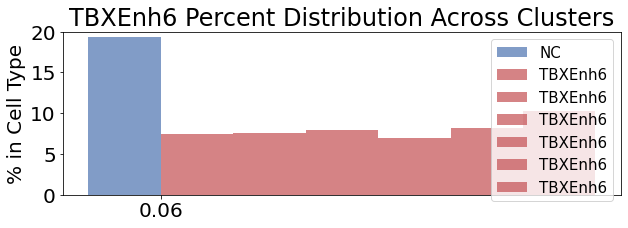

In [29]:
plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(10,3))

N=1
ind = np.arange(N)

width = 0.12       # the width of the bars: can also be len(x) sequence

ax.bar(ind, NC_Percents, width, alpha = 0.7, label='NC', color = '#4c72b0')
ax.bar(ind+width, TBXEnh1_Percents, width,  alpha = 0.7,
       label=target, color ='#c44e52')
ax.bar(ind+width+width, TBXEnh2_Percents, width,  alpha = 0.7,
       label=target, color ='#c44e52')
ax.bar(ind+width+width+width, TBXEnh3_Percents, width,  alpha = 0.7,
       label=target, color ='#c44e52')
ax.bar(ind+width+width+width+width, TBXEnh4_Percents, width,  alpha = 0.7,
       label=target, color ='#c44e52')
ax.bar(ind+width+width+width+width+width, TBXEnh5_Percents, width,  alpha = 0.7,
       label=target, color ='#c44e52')
ax.bar(ind+width+width+width+width+width+width, TBXEnh6_Percents, width,  alpha = 0.7,
       label=target, color ='#c44e52')

ax.set_ylabel('% in Cell Type')
ax.set_title(target +  ' Percent Distribution Across Clusters')
plt.xticks(ind + width*.5)
plt.ylim(0,20)
ax.legend()
plt.legend(prop={'size': 15})
plt.savefig('./All_TBX5Enh_Percentage_Bar.pdf')
plt.show()